# Prelims

Please enter the full path to the root folder of this project. If it is on drive mount the disk, [click here to see an example](https://colab.research.google.com/notebooks/io.ipynb).

In [4]:
PATH_PROJ = '/content/drive/MyDrive/Javeriana/Thesis' #@param {type:"string"}

In [ ]:
!nvidia-smi

Mon Jan  3 17:34:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!pip install git+https://github.com/facebookresearch/esm.git
!pip install biopython
!pwd
!ls

  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-t93d47r0
  Running command git clone -q https://github.com/facebookresearch/esm.git /tmp/pip-req-build-t93d47r0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for fair-esm: filename=fair_esm-0.4.0-py3-none-any.whl size=38574 sha256=710fbfff6b07724ebd8da417a83937bfd017ca2026a42c4ba67c0c8b8181ccd8
  Stored in directory: /tmp/pip-ephem-wheel-cache-5aw2gngt/wheels/5c/8e/11/307eca5379b418a9989ef4d24ead655755f2500a577ec95208
Successfully built fair-esm
     |████████████████████████████████| 2.3 MB 8.2 MB/s 
/content
drive  sample_data


In [7]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.5 MB/s 


In [8]:
EMB_LAYER = 33
EMB_LENGTH = 1280
SIZE_SAMPLE = 16435
DECIMALS_POINTS_EMB = 9
LABEL_CLASS = ["No interaction", "Interaction"]
THRESHOLD = 0.671

# Loading librarys and dataset

In [9]:
import time
from typing import List, Tuple

import esm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb
import keras_tuner as kt
import tensorflow as tf
import torch
from Bio import SeqIO
from imblearn.combine import SMOTETomek
from keras import metrics
from keras import utils
import keras.backend as K
from keras.layers import (Concatenate, Conv1D, Dense,
                          Flatten, Input, MaxPooling1D)
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_recall_curve, auc
from tensorflow.keras import regularizers

In [10]:
sb.set_theme()

In [11]:
proteins_info = pd.read_csv(f"{PATH_PROJ}/string_data/59689/59689.protein.info.v11.5.txt", sep="	")
proteins_links = pd.read_csv(f"{PATH_PROJ}/string_data/59689/59689.protein.physical.links.detailed.v11.5.txt", sep=" ")

# EDA

## Preliminary data

In [ ]:
proteins_info.dtypes

#string_protein_id    object
preferred_name        object
protein_size           int64
annotation            object
dtype: object

In [ ]:
proteins_links.dtypes

protein1          object
protein2          object
experimental       int64
database           int64
textmining         int64
combined_score     int64
dtype: object

In [ ]:
print("Number of posible proteins: {}".format(proteins_info.shape[0]))

Number of posible proteins: 32667


In [ ]:
print("Number of posible interactions: {}".format(proteins_links.shape[0]))

Number of posible interactions: 5988094


## Size of proteins

In [ ]:
proteins_info.head(5)

,#string_protein_id,preferred_name,protein_size,annotation
0,59689.Al_scaffold_0001_1000,Al_scaffold_0001_1000,185,Predicted protein
1,59689.Al_scaffold_0001_1004,Al_scaffold_0001_1004,412,Predicted protein
2,59689.Al_scaffold_0001_1015,Al_scaffold_0001_1015,214,Predicted protein
3,59689.Al_scaffold_0001_1024,Al_scaffold_0001_1024,371,Predicted protein
5,59689.Al_scaffold_0001_1039,Al_scaffold_0001_1039,539,Predicted protein


In [ ]:
proteins_info.describe()

,protein_size
count,32667.000000
mean,360.388006
std,292.790029
min,49.000000
25%,154.000000
50%,295.000000
75%,476.000000
max,5090.000000


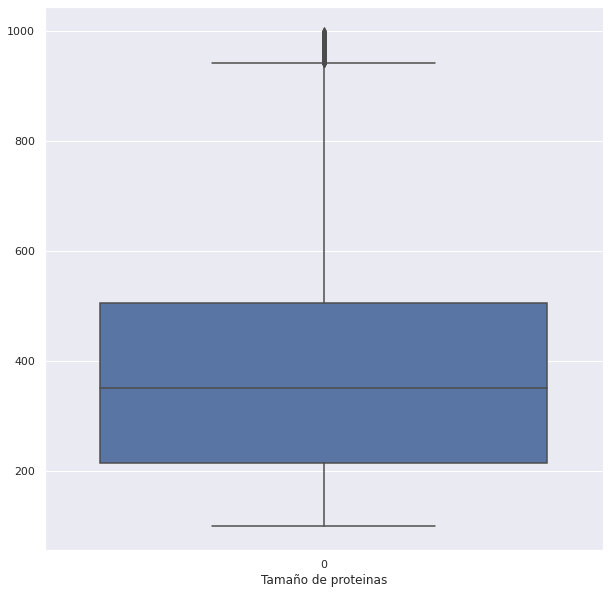

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
sb.boxplot(data=proteins_info["protein_size"], ax=ax)
ax.set_xlabel("Tamaño de proteinas")
plt.show()

## Description of links

In [ ]:
proteins_links.head(5)

,protein1,protein2,experimental,database,textmining,combined_score,label
0,59689.Al_scaffold_0001_1015,59689.scaffold_604085.1,46,254,0,257,0
1,59689.Al_scaffold_0001_1015,59689.fgenesh2_kg.8__1654__AT5G57380.1,48,269,0,274,0
2,59689.Al_scaffold_0001_1015,59689.scaffold_302478.1,53,311,0,319,0
3,59689.Al_scaffold_0001_1015,59689.fgenesh2_kg.1__172__AT1G02580.1,46,254,0,257,0
4,59689.Al_scaffold_0001_1015,59689.Al_scaffold_0001_4512,53,311,0,319,0


In [ ]:
proteins_links.describe()

,experimental,database,textmining,combined_score
count,5.988094e+06,5.988094e+06,5.988094e+06,5.988094e+06
mean,1.646957e+02,2.245799e+02,3.672544e+01,3.398801e+02
std,1.769864e+02,1.793495e+02,9.453137e+01,1.959154e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+02
25%,5.800000e+01,1.360000e+02,0.000000e+00,2.010000e+02
50%,9.200000e+01,1.930000e+02,0.000000e+00,2.670000e+02
75%,1.990000e+02,2.800000e+02,0.000000e+00,4.020000e+02
max,9.650000e+02,9.990000e+02,9.810000e+02,9.990000e+02


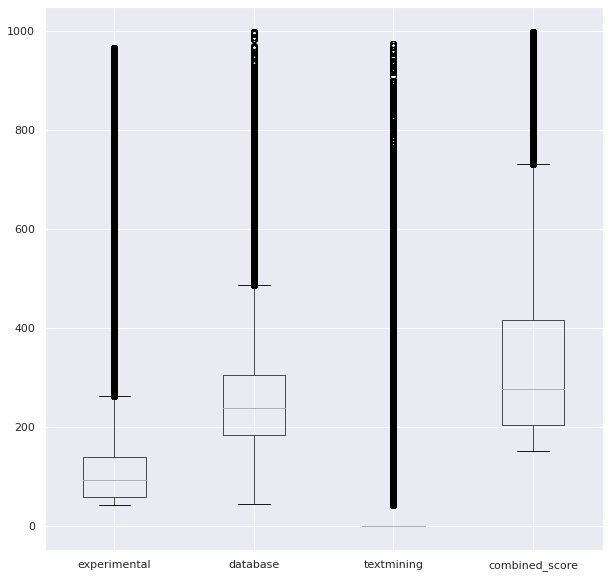

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
proteins_links.boxplot(column=["experimental", "database", "textmining", "combined_score"])

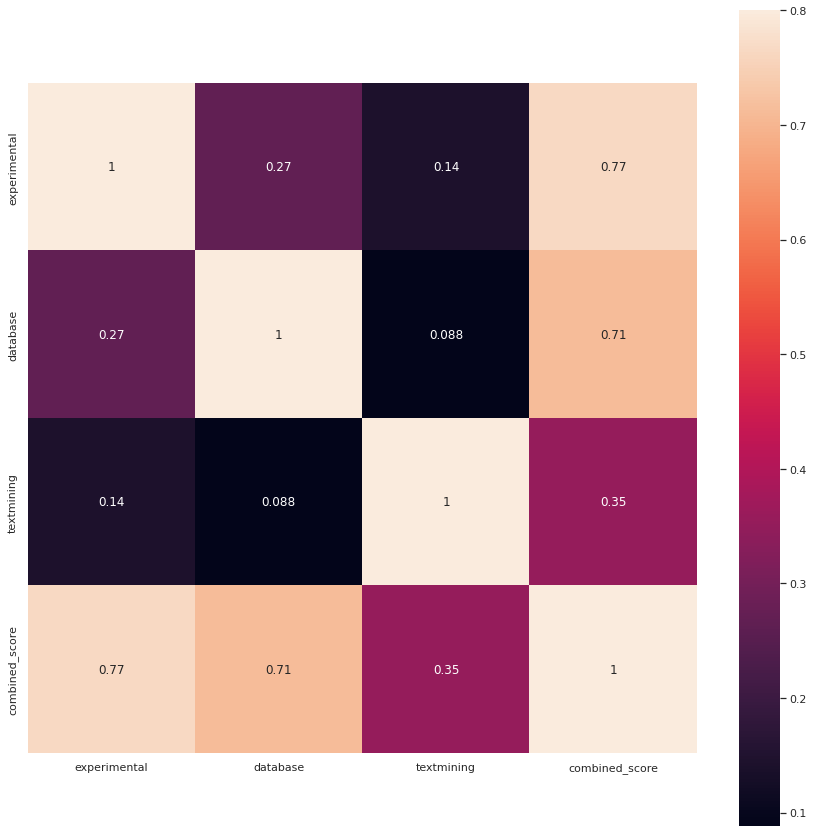

In [ ]:
C_mat = proteins_links[["experimental", "database", "textmining", "combined_score"]].corr()
fig = plt.figure(figsize = (15,15))
sb.heatmap(C_mat, vmax = .8, square = True, annot=True)
plt.show()

# Filtering proteins and pair-interation

## Filtering interactions
Considering that the combined score will be the value of the links to predict, and the high correlation between the experimental-combined score and database-combined score channels, we will consider only the interaction pairs containing channels via experimental and database.

In [ ]:
unreliable_links = proteins_links[(proteins_links["experimental"] == 0) | (proteins_links["database"] == 0)].index
proteins_links.drop(unreliable_links, axis=0, inplace=True)
proteins_links.reset_index(inplace=True, drop=True)
print("Number of posible interactions: {}".format(proteins_links.shape[0]))

Number of posible interactions: 4716302


## Filtering by proteins
In order to be more confident about the combined score of the interactions (confidence level of the existence of the interaction), we will filter out proteins that do not have a defined biological function. This, by defining the assumption that given a pair of proteins with defined annotation, the confidence level of the interaction between these proteins will be more reliable.



In [ ]:
noanotation_proteins = proteins_info[proteins_info.annotation.isin(["annotation not available"])].index
uncharacterized_proteins = proteins_info[proteins_info.annotation.isin(["Uncharacterized protein"])].index

Getting the names of proteins without accurated annotation

In [ ]:
noanotation_proteins_flat = proteins_info.iloc[noanotation_proteins, [0]]["#string_protein_id"]
uncharacterized_proteins_flat = proteins_info.iloc[uncharacterized_proteins, [0]]["#string_protein_id"]

Deleting links with one protein or both of them without accurated annotation

In [ ]:
noanotation_links = proteins_links[(proteins_links["protein1"].isin(noanotation_proteins_flat)) | (proteins_links["protein2"].isin(noanotation_proteins_flat))].index
proteins_links.drop(noanotation_links, axis=0, inplace=True)
proteins_links.reset_index(inplace=True, drop=True)

uncharacterized_links = proteins_links[(proteins_links["protein1"].isin(uncharacterized_proteins_flat)) | (proteins_links["protein2"].isin(uncharacterized_proteins_flat))].index
proteins_links.drop(uncharacterized_links, axis=0, inplace=True)
proteins_links.reset_index(inplace=True, drop=True)

In [ ]:
print("Number of posible interactions: {}".format(proteins_links.shape[0]))

Number of posible interactions: 1788782


Gettting again proteins without accurated annotation and deleting them

In [ ]:
noanotation_proteins = proteins_info[proteins_info.annotation.isin(["annotation not available"])].index
proteins_info.drop(noanotation_proteins, axis=0, inplace=True)
proteins_info.reset_index(inplace=True, drop=True)

uncharacterized_proteins = proteins_info[proteins_info.annotation.isin(["Uncharacterized protein"])].index
proteins_info.drop(uncharacterized_proteins, axis=0, inplace=True)
proteins_info.reset_index(inplace=True, drop=True)

In [ ]:
print("Number of posible proteins: {}".format(proteins_info.shape[0]))

Number of posible proteins: 18198


## Filtering proteins by secuence length 
The dataset has a great variety of proteins, with different length of sequences, we will filter out those proteins with very small and very large sequence size, in order to reduce the complexity of the future model. Given previous work reviewed, it is common to work with chains larger than 100 and smaller than a thousand amino acids.

In [ ]:
nofit_proteins = proteins_info[(proteins_info.protein_size < 100) | (proteins_info.protein_size > 1000)].index
nofit_proteins_flat = proteins_info.iloc[nofit_proteins, [0]]["#string_protein_id"]
nofit_links = proteins_links[(proteins_links["protein1"].isin(nofit_proteins_flat)) | (proteins_links["protein2"].isin(nofit_proteins_flat))].index
proteins_links.drop(nofit_links, axis=0, inplace=True)
proteins_info.drop(nofit_proteins, axis=0, inplace=True)

In [ ]:
proteins_links.shape

(1322810, 6)

In [ ]:
proteins_info.shape

(15109, 4)

## Checking all proteins are availables
We verify that all the previously filtered protein pairs are available in the additional dataset, and therefore, that their respective amino acid sequences are available.


In [ ]:
noavailables_proteins = proteins_links[(~proteins_links["protein1"].isin(proteins_info["#string_protein_id"]) | ~proteins_links["protein2"].isin(proteins_info["#string_protein_id"]))].index

In [ ]:
print("Number of proteins no availables: %d" % noavailables_proteins.shape[0])

Number of proteins no availables: 0


## Summary

In [ ]:
print("Number of proteins: %d" % proteins_info.shape[0])
print("Number of interactions: %d" % proteins_links.shape[0])

Number of proteins: 15109
Number of interactions: 1322810


## Distribution 

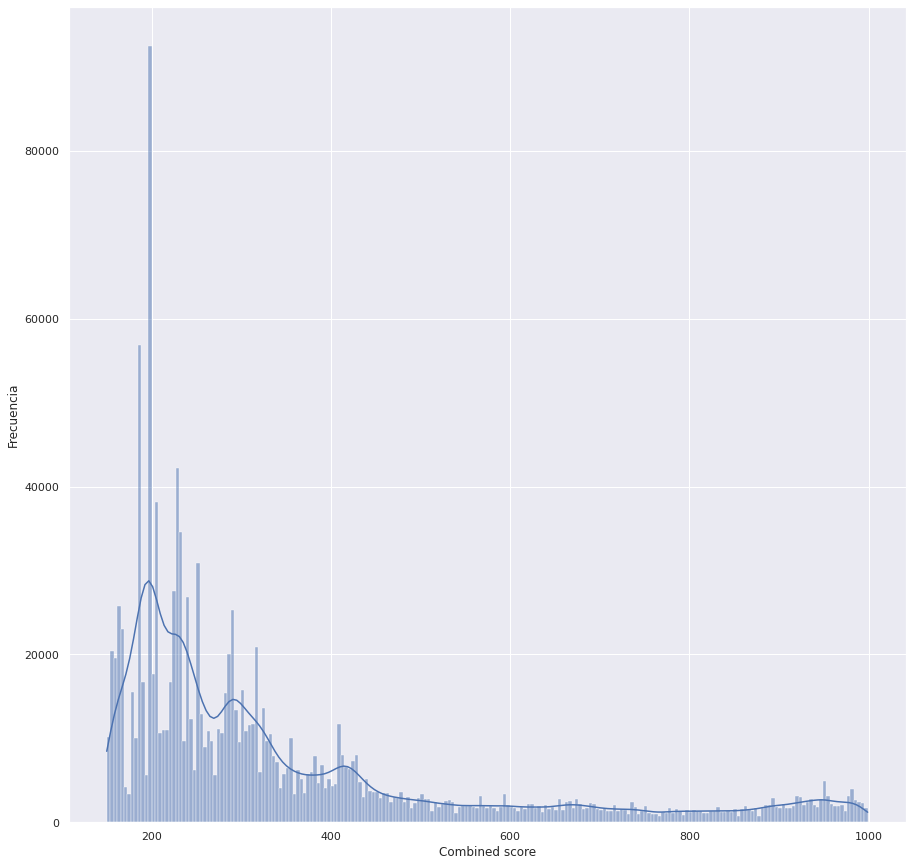

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sb.histplot(data=proteins_links["combined_score"], kde=True, ax=ax)
ax.set_ylabel("Frecuencia")
ax.set_xlabel("Combined score")
plt.show()

In [ ]:
pre_labels = [0 for _ in range(proteins_links.shape[0])]
proteins_links.insert(proteins_links.columns.size, "label", pre_labels, True)

proteins_links.at[proteins_links[proteins_links.combined_score >= 700].index, "label"] = 1

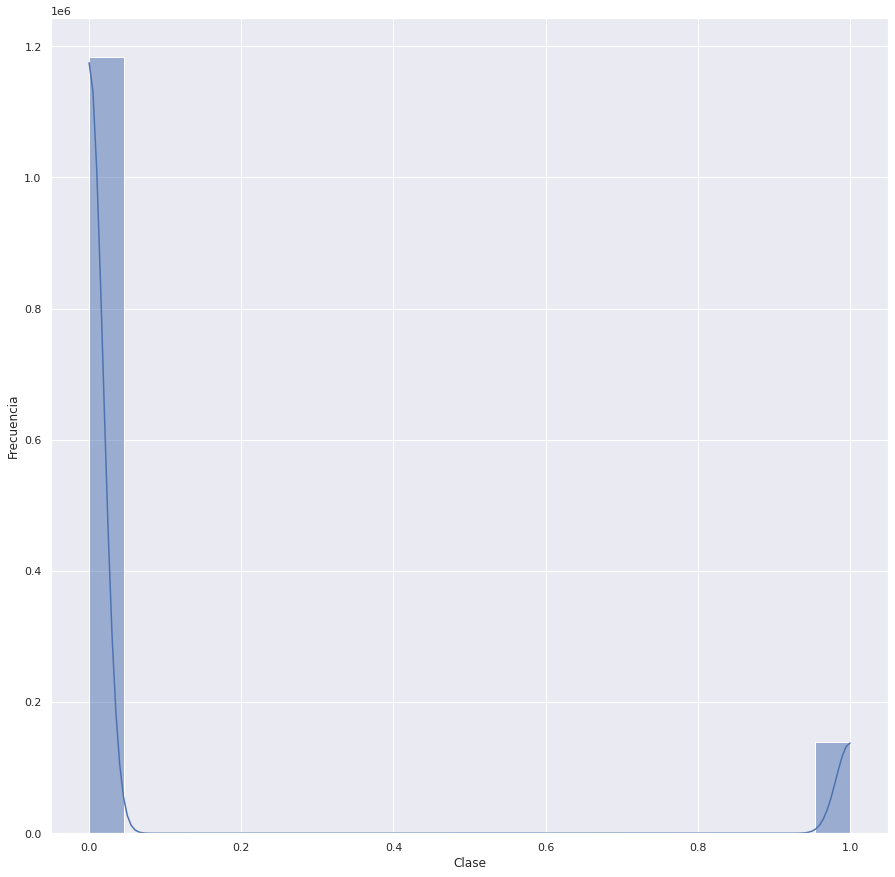

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sb.histplot(data=proteins_links["label"], kde=True, ax=ax)
ax.set_ylabel("Frecuencia")
ax.set_xlabel("Clase")
plt.show()

In [ ]:
proteins_links.drop(["label"], axis=1, inplace=True)

# Loading sequences

In [ ]:
empty_sequence = ["" for _ in range(proteins_info.shape[0])]
proteins_info.insert(proteins_info.columns.size, "sequence", empty_sequence, True)

In [ ]:
secuences_file = f"{PATH_PROJ}/string_data/59689/59689.protein.sequences.v11.5.fa"
with open(secuences_file) as handle:
    for record in SeqIO.parse(handle, "fasta"):
        protein_index = proteins_info[proteins_info["#string_protein_id"] == record.id].index
        if protein_index.size:
            proteins_info.at[protein_index, "sequence"] = str(record.seq)

In [ ]:
nosequence_proteins = proteins_info[proteins_info["sequence"] == ""].index
print("Number of proteins without sequence %d" % nosequence_proteins.size)

Number of proteins without sequence 0


# Embedding secuence: SOTA tranformer

In [ ]:
esm1b, esm1b_alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
esm1b = esm1b.eval().cuda()
esm1b_batch_converter = esm1b_alphabet.get_batch_converter()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S-contact-regression.pt


In [ ]:
def embedding_pair_proteins(data: List[Tuple[str, str]], model: esm.model.ProteinBertModel, esm1b_batch_converter:esm.data.BatchConverter
) -> List[torch.Tensor]:
    _, _, esm1b_batch_tokens = esm1b_batch_converter(data)
    esm1b_batch_tokens = esm1b_batch_tokens.cuda()

    with torch.no_grad():
        results = esm1b(esm1b_batch_tokens, repr_layers=[EMB_LAYER], return_contacts=False)
    token_representations = results["representations"][EMB_LAYER]

    sequence_representations = []
    for i, (_, seq) in enumerate(data):
        cuda_representation = token_representations[i, 1 : len(seq) + 1].mean(0)
        cpu_representation = cuda_representation.cpu().numpy()
        sequence_representations.append(cpu_representation)
    return sequence_representations

## Sampling data to embedding
It is necessary to sample the total dataset, to have a minimum embedding time, the average embedding time of a protein pair is 0.5 seconds (using GPU), quite low, but considering the 1,322,810 interactions, the embedding time is estimated in days, not feasible at all.

In [ ]:
test_emb_data = [
    ("protein1", "MNFRSILIRASGYPQLWKRACTTVAAPLSADLCEGDSKKAKAASRKREKEKMFEKLQSLTGEYLDLITKQQKEKRTSLSVADLAGWAKRLFKDGKLDHALEIYGWMEKKKMKFSASQFADYVEVVGDLKGFEAAKEVFYRIDPEFNQMDLDAKNLPAFLMLVRFDALAFEDPVAERRREHFLVGRRGEYAMFEKRGRRGLPSLEDEDPLPLRRY"),
    ("protein2", "MVTDDSDSSGRIKSHVDDDEEDRLEGLENRLSELKRKIQGERVRSIKEKFEANRKKVDVHVSPFSSAASSRATAGDNGNSNVFSSRMEIPLCKLNGFSHGVGDRDYVPTKDVTAASVKLPIAERIPPYTTWIFLDRNQRMAEDQSVVGRRQIYYERHGGETLICSDSEEEPEPEEEKREYSEGEDSVIWLIGQEYGMGEEVQDSLCQFLSVDASDILGRYNELKLKDEQNTENFSNSGFKLGISLEKDLGAALDSFDNLFCRRCLVFDCRLHGCSQPLISASEKQSYWSDYEGDRKPCSKHCYLQVEVKAVREVPKAEEKASKEECSKAISSDDPHDAATGVNLQVEKTDIGFKNLDSSSGVEQEHGIRGKREVPNLEDSNDLPNLSNKKQKTTASDTKMSLVNSTPSLDQAFDSSKGDQSETVETNNVNRDSGADSKEVAEPLPDILVLDGGSSVCQPDHGSGNGSIIIGEMSEKSQPSTEWNPIEKDLYLKGVEIFGRNSCLIARNLLSGLKTCLDVSSYMRENEVSVFRRSSTPNLLLDDGRTDPGNDDDEVPPRTRLFRRKGKTRKLKYSTKSAGHPSVWKRIAGGKNQSCKQYTPCGCLSMCGKDCPCLTNETCCEKYCGCSKSCKNRFRGCHCAKSQCRSRQCPCFAAGRECDPDVCRNCWVSCGDGSLGEAPRRGEGQCGNMRLLLRQQQRILLGKSDVAGWGAFLKNSVSKNEYLGEYTGELISHREADKRGKIYDRANSSFLFDLNDQYVLDAQRKGDKLKFANHSAKPNCYAKVMFVAGDHRVGIFANERIEASEELFYDYRYGPDQAPAWARKPEGSKKDDSAITHRRARKHQSH"),
]

TEST_EMB = 5
times_emb = []

for _ in range(TEST_EMB):
    start_time = time.time()
    embedding_pair_proteins(test_emb_data, esm1b, esm1b_batch_converter)
    times_emb.append(time.time()- start_time)

avg_time_emb = sum(times_emb)/TEST_EMB
estimated_total_time =  proteins_links.shape[0]*avg_time_emb/3600
print("Average time of embedding: %3g" % avg_time_emb)
print("Estimated time of embedding: %3g h" % estimated_total_time)

Average time of embedding: 0.505195
Estimated time of embedding: 185.632 h


In [ ]:
sample_proteins_links = proteins_links.sample(SIZE_SAMPLE)

*Take care, runtime 5 hours average, load dataset*

In [ ]:
protein1_embs_raw = []
protein2_embs_raw = []

acc_rows = 1
for index, row in sample_proteins_links.iterrows():
    start_time = time.time()
    protein1_name = row["protein1"]
    protein2_name = row["protein2"]

    protein1 = proteins_info[proteins_info["#string_protein_id"] == protein1_name]
    protein2 = proteins_info[proteins_info["#string_protein_id"] == protein2_name]

    protein1_index = protein1.index[0]
    protein2_index = protein2.index[0]

    sequences_data = []
    sequences_data.append((protein1, protein1.at[protein1_index, "sequence"]))
    sequences_data.append((protein2, protein2.at[protein2_index, "sequence"]))

    emb_1, emb_2 = embedding_pair_proteins(sequences_data, esm1b, esm1b_batch_converter)
    protein1_embs_raw.append(emb_1)
    protein2_embs_raw.append(emb_2)

    if not acc_rows % 173:
        print("Progressing... %.0f%%" % (acc_rows/SIZE_SAMPLE*100))
    acc_rows += 1


Progressing... 1%
Progressing... 2%
Progressing... 3%
Progressing... 4%
Progressing... 5%
Progressing... 6%
Progressing... 7%
Progressing... 8%
Progressing... 9%
Progressing... 11%
Progressing... 12%
Progressing... 13%
Progressing... 14%
Progressing... 15%
Progressing... 16%
Progressing... 17%
Progressing... 18%
Progressing... 19%
Progressing... 20%
Progressing... 21%
Progressing... 22%
Progressing... 23%
Progressing... 24%
Progressing... 25%
Progressing... 26%
Progressing... 27%
Progressing... 28%
Progressing... 29%
Progressing... 31%
Progressing... 32%
Progressing... 33%
Progressing... 34%
Progressing... 35%
Progressing... 36%
Progressing... 37%
Progressing... 38%
Progressing... 39%
Progressing... 40%
Progressing... 41%
Progressing... 42%
Progressing... 43%
Progressing... 44%
Progressing... 45%
Progressing... 46%
Progressing... 47%
Progressing... 48%
Progressing... 49%
Progressing... 51%
Progressing... 52%
Progressing... 53%
Progressing... 54%
Progressing... 55%
Progressing... 56%
Pr

In [ ]:
sample_proteins_links.to_csv(f"{PATH_PROJ}/dataset/interactions_raw.csv", index=False)

In [ ]:
protein1_embs = np.array(protein1_embs_raw)
np.savetxt(f"{PATH_PROJ}/dataset/P1EMBS.csv", protein1_embs)

protein2_embs = np.array(protein2_embs_raw)
np.savetxt(f"{PATH_PROJ}/dataset/P2EMBS.csv", protein2_embs)

# Preparing dataset 

## Loading pre-saved dataset
Generating the embeddings for each protein pair is very time consuming, previously a dataset was created with a significant sample of the total filtered interactions. Load this dataset with the embeddings per protein pair.

In [ ]:
sample_proteins_links = pd.read_csv(f"{PATH_PROJ}/dataset/interactions_raw.csv")
protein1_embs = np.loadtxt(f"{PATH_PROJ}/dataset/P1EMBS.csv")
protein2_embs = np.loadtxt(f"{PATH_PROJ}/dataset/P2EMBS.csv")

In [ ]:
protein_names = sample_proteins_links[["protein1", "protein2"]]

In [ ]:
columns_to_delete = ["experimental", "database", "textmining"]
sample_proteins_links.drop(columns_to_delete, axis=1, inplace=True)

In [ ]:
sample_proteins_links.rename(columns={"combined_score": "score"}, inplace=True)

## Label encoding

The interaction between proteins is weighted with a score from 0 to 1000, this score represents the level of confidence or certainty that the pair of proteins interact with each other, the higher the score the higher the confidence. Those interactions that have a score greater than 700, it is considered that the existence of the interaction between the pair of proteins is very probable, high confidence. We will assign a class to each interaction, those with a score above 700 will be assigned class one (1), the others class zero (0). This in order to create the classifier model.

In [ ]:
pre_labels = [0 for _ in range(sample_proteins_links.shape[0])]
sample_proteins_links.insert(sample_proteins_links.columns.size, "label", pre_labels, True)

sample_proteins_links.at[sample_proteins_links[sample_proteins_links.score >= 700].index, "label"] = 1

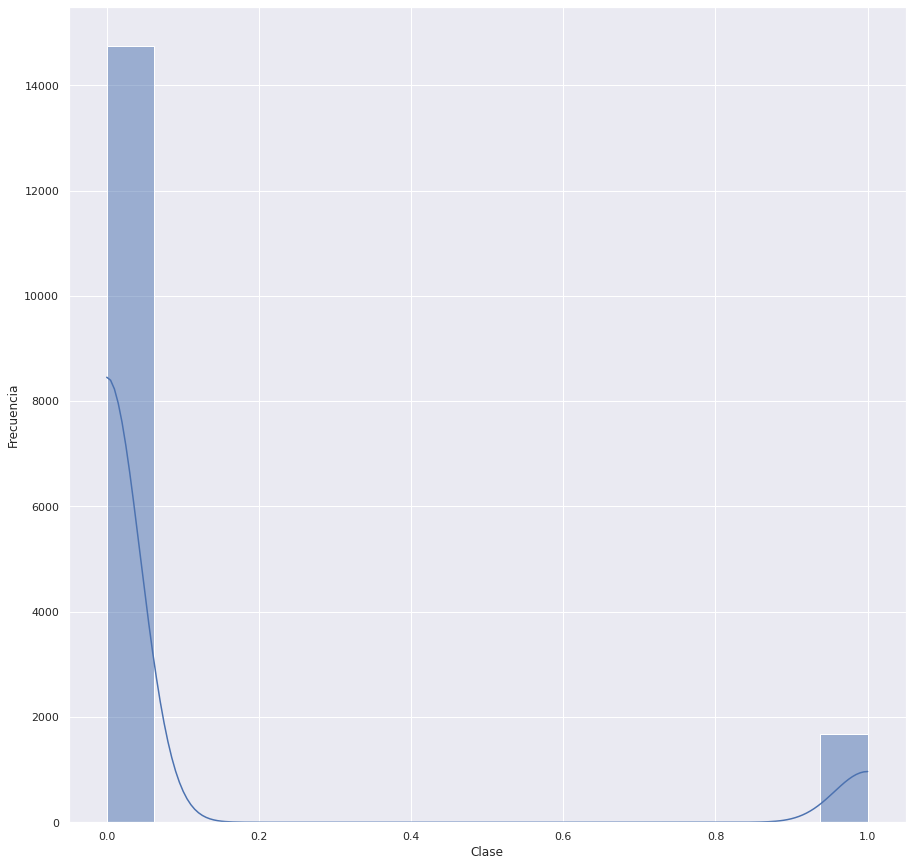

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sb.histplot(data=sample_proteins_links["label"], kde=True, ax=ax)
ax.set_ylabel("Frecuencia")
ax.set_xlabel("Clase")
plt.show()

In [ ]:
print("No. no-interactions: %d" % len(sample_proteins_links[sample_proteins_links["label"] == 0]))
print("No. interactions: %d" % len(sample_proteins_links[sample_proteins_links["label"] == 1]))

No. no-interactions: 14752
No. interactions: 1683


## Splitting

### Train and test set

In [ ]:
dataset_full = np.stack((protein1_embs, protein2_embs), axis=1)
labels = sample_proteins_links["label"].to_numpy()

In [ ]:
dataset_full.shape

(16435, 2, 1280)

In [ ]:
X_train_full, X_test_full, Y_train, Y_test = train_test_split(dataset_full, labels, test_size = 0.3, random_state=666)

In [ ]:
X_train_p1 = X_train_full[:, 0, :]
X_train_p2 = X_train_full[:, 1, :]

X_test_p1 = X_test_full[:, 0, :]
X_test_p2 = X_test_full[:, 1, :]

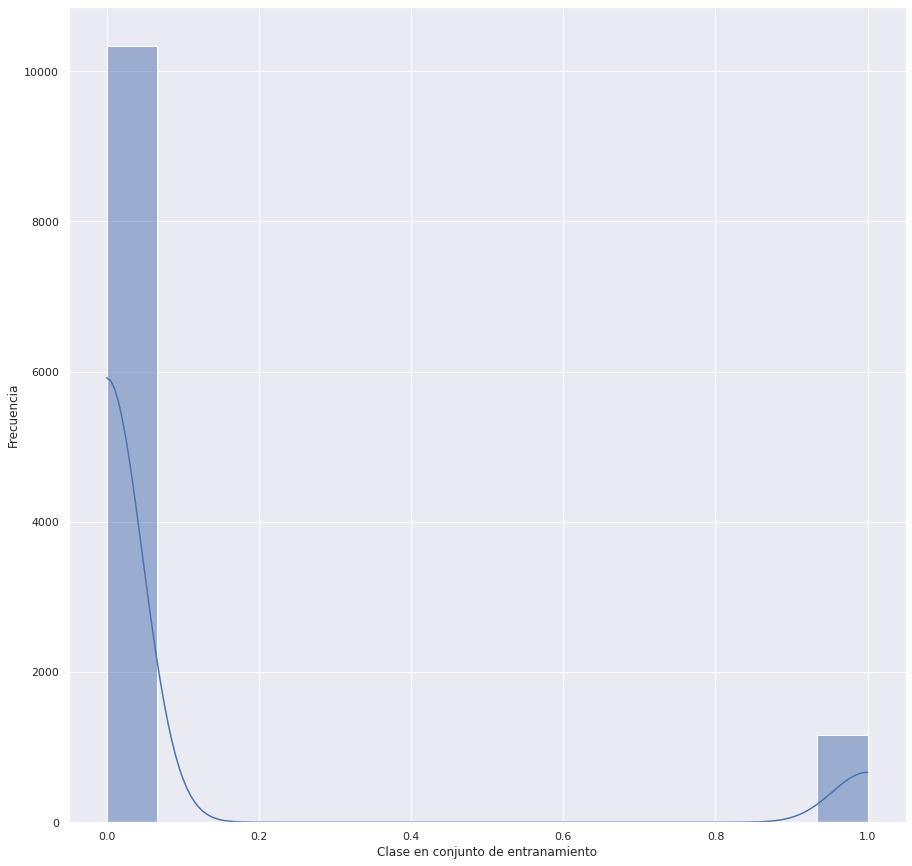

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sb.histplot(data=Y_train, kde=True, ax=ax)
ax.set_ylabel("Frecuencia")
ax.set_xlabel("Clase en conjunto de entranamiento")
plt.show()

In [ ]:
print("No. no-interactions: %d" % len(Y_train[Y_train == 0]))
print("No. interactions: %d" % len(Y_train[Y_train == 1]))

No. no-interactions: 10340
No. interactions: 1164


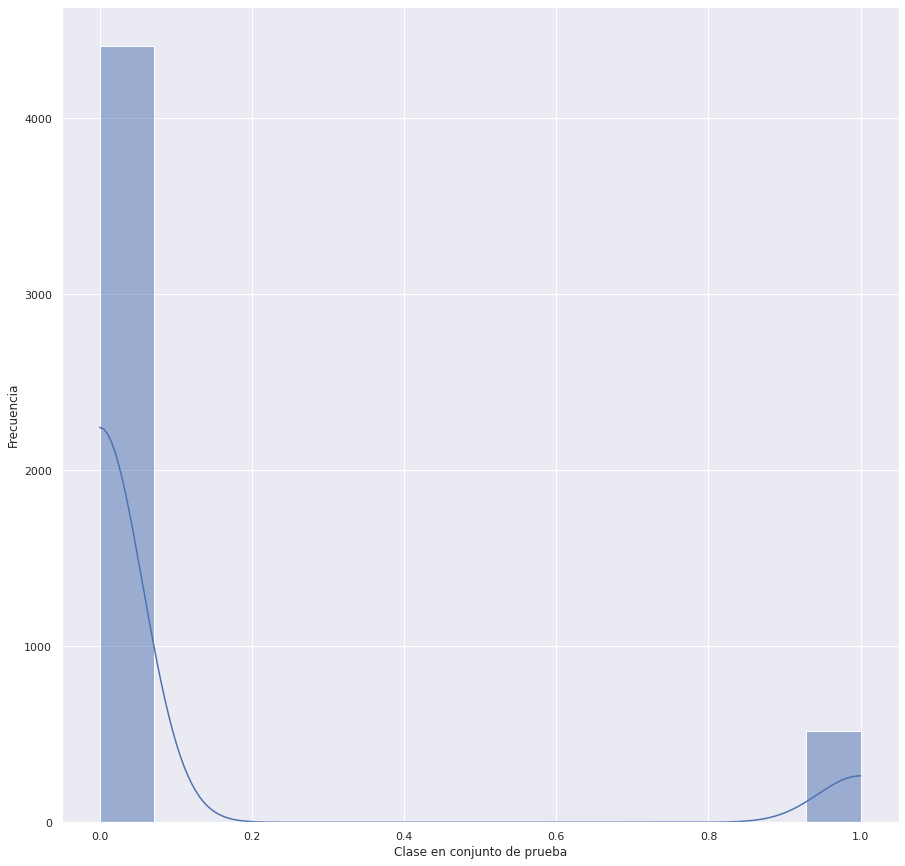

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sb.histplot(data=Y_test, kde=True, ax=ax)
ax.set_ylabel("Frecuencia")
ax.set_xlabel("Clase en conjunto de prueba")
plt.show()

In [ ]:
print("No. no-interactions: %d" % len(Y_test[Y_test == 0]))
print("No. interactions: %d" % len(Y_test[Y_test == 1]))

No. no-interactions: 4412
No. interactions: 519


### Validation set

In [ ]:
train_dataset_full = np.stack((X_train_p1, X_train_p2), axis=1)
X_train_final_full, X_val_full, Y_train_final, Y_val = train_test_split(train_dataset_full, Y_train, test_size = 0.33, random_state=666)

In [ ]:
X_train_final_p1 = X_train_final_full[:, 0, :]
X_train_final_p2 = X_train_final_full[:, 1, :]

X_val_p1 = X_val_full[:, 0, :]
X_val_p2 = X_val_full[:, 1, :]

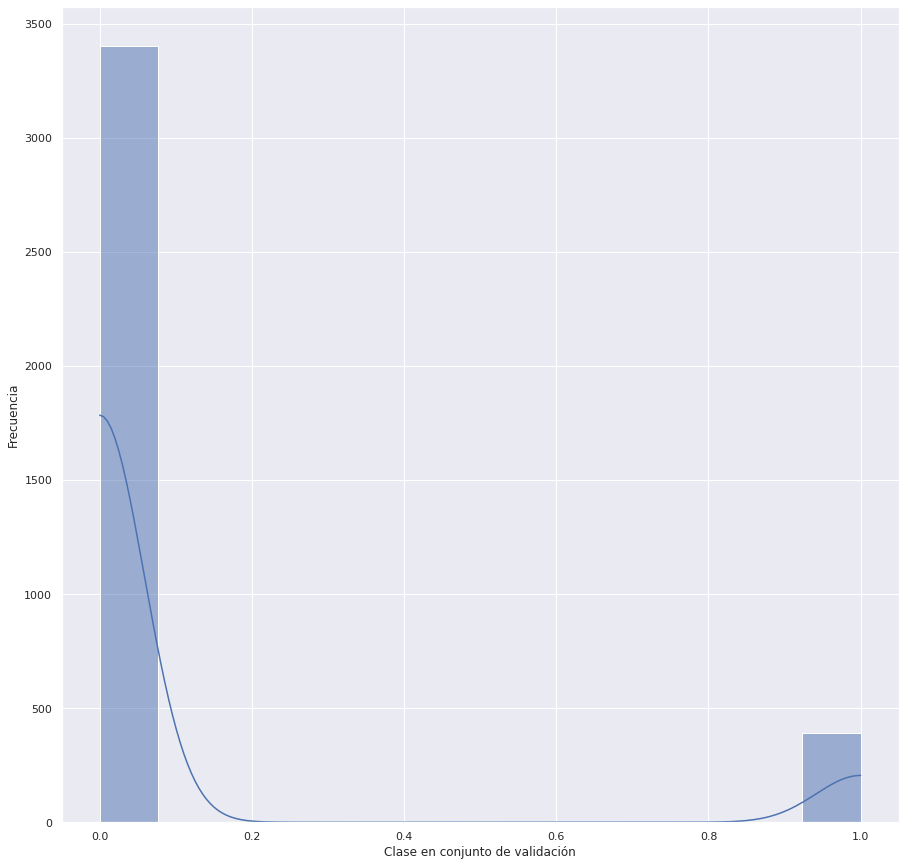

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sb.histplot(data=Y_val, kde=True, ax=ax)
ax.set_ylabel("Frecuencia")
ax.set_xlabel("Clase en conjunto de validación")
plt.show()

In [ ]:
print("No. no-interactions: %d" % len(Y_val[Y_val == 0]))
print("No. interactions: %d" % len(Y_val[Y_val == 1]))

No. no-interactions: 3405
No. interactions: 392


## Over and under sampling

In [ ]:
X_train_as_matrix = np.concatenate((X_train_final_p1, X_train_final_p2), axis=1)

In [ ]:
print("Train dataset size: (%d,%d)" % X_train_as_matrix.shape)

Train dataset size: (7707,2560)


In [ ]:
smenn = SMOTETomek(n_jobs=-1)
X_train_as_matrix_smenn, Y_train_smenn = smenn.fit_resample(X_train_as_matrix, Y_train_final)

In [ ]:
print("Train dataset size: (%d,%d)" % X_train_as_matrix_smenn.shape)

Train dataset size: (13870,2560)


In [ ]:
X_train_final_smenn_p1 = X_train_as_matrix_smenn[:, :EMB_LENGTH]
X_train_final_smenn_p2 = X_train_as_matrix_smenn[:, EMB_LENGTH:]

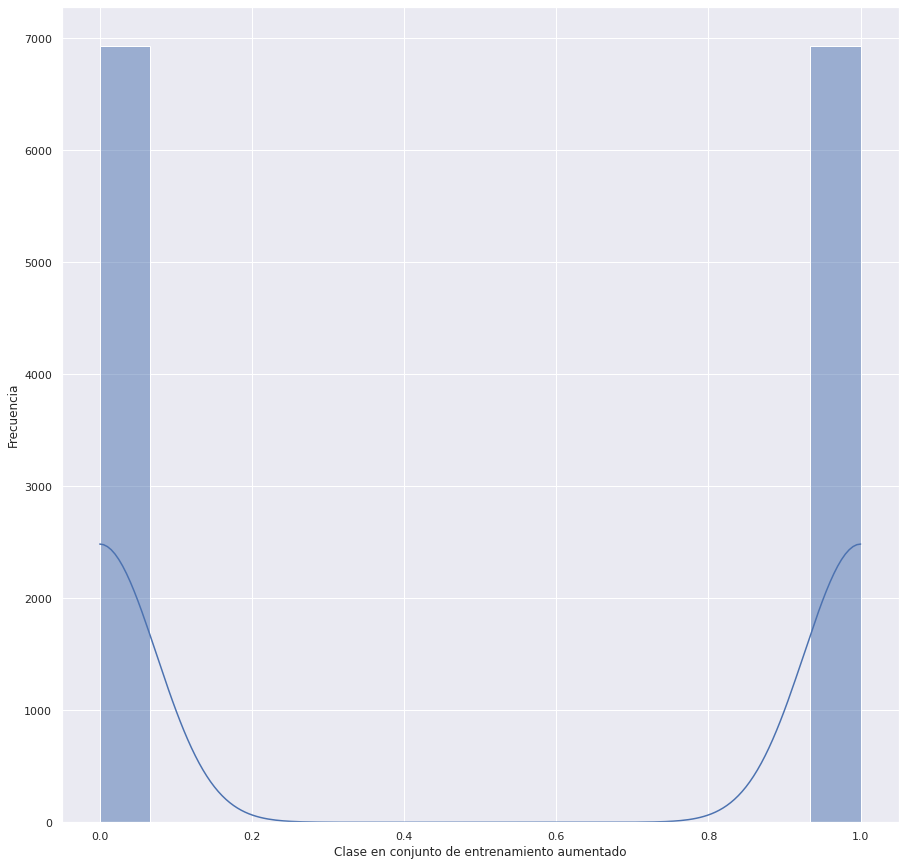

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sb.histplot(data=Y_train_smenn, kde=True, ax=ax)
ax.set_ylabel("Frecuencia")
ax.set_xlabel("Clase en conjunto de entrenamiento aumentado")
plt.show()

In [ ]:
print("No. no-interactions: %d" % len(Y_train_smenn[Y_train_smenn == 0]))
print("No. interactions: %d" % len(Y_train_smenn[Y_train_smenn == 1]))

No. no-interactions: 6934
No. interactions: 6934


# Building model

In [ ]:
def F1(threshold=0.5):
    def f1_score(y_true, y_pred):
        y_pred_thresholded = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), "float32")
        y_true_cast = K.cast(y_true, "float32")

        true_positives = K.sum(K.round(K.clip(y_true * y_pred_thresholded, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_cast, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_thresholded, 0, 1)))
        
        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        f1_val = 2*(precision*recall) / (precision + recall + K.epsilon())
        return f1_val
    return f1_score

In [ ]:
def build_model(hyperparam=None):
    emb1_input = Input(shape=(EMB_LENGTH), name="Embedding protein 1")
    emb2_input = Input(shape=(EMB_LENGTH), name="Embedding protein 2")

    filter_conv_1 = hyperparam.Int("filter_conv_1", 2, 20)
    filter_conv_2 = hyperparam.Int("filter_conv_2", 2, 20)
    #filter_conv_3 = hyperparam.Int("filter_conv_3", 2, 20)

    kernel_size_conv_1 = hyperparam.Int("kernel_size_conv_1", 2, 10)
    kernel_size_conv_2 = hyperparam.Int("kernel_size_conv_2", 2, 10)
    #kernel_size_conv_3 = hyperparam.Int("kernel_size_conv_3", 2, 10)

    pool_size_conv_1 = hyperparam.Int("pool_size_conv_1", 2, 10)
    pool_size_conv_2 = hyperparam.Int("pool_size_conv_2", 2, 10)
    #pool_size_conv_3 = hyperparam.Int("pool_size_conv_3", 2, 10)

    units_hidden = hyperparam.Int("units_hidden", 10, 1000)
    activation_hidden = hyperparam.Choice("activation_hidden", values=["relu", "softmax"])

    convolutional_module1 = Sequential([
        Conv1D(filters=filter_conv_1, kernel_size=kernel_size_conv_1, input_shape=(EMB_LENGTH, 1), bias_regularizer=regularizers.l1_l2(),),
        MaxPooling1D(pool_size=pool_size_conv_1, name="Max_Pooling", strides=1),

        Conv1D(filters=filter_conv_2, kernel_size=kernel_size_conv_2, bias_regularizer=regularizers.l1_l2(),),
        MaxPooling1D(pool_size=pool_size_conv_2, strides=1),
        Flatten(),
    ], name="Mod_Convolutions_1")
    
    convolution1_p1 = convolutional_module1(emb1_input)
    convolution1_p2 = convolutional_module1(emb2_input)

    merged = Concatenate(name="Concat")([convolution1_p1, convolution1_p2])

    predition_module = Sequential([
        Dense(units_hidden, activation=activation_hidden, name="Fully_Connected", bias_regularizer=regularizers.l1_l2(),),
        Dense(1, activation="sigmoid", bias_regularizer=regularizers.l1_l2(),)
    ], name="Mod_Predition")
    prediction = predition_module(merged)
    model = Model(inputs=[emb1_input, emb2_input], outputs=prediction)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[metrics.BinaryAccuracy(threshold=THRESHOLD, name="accuracy"), metrics.Precision(thresholds=THRESHOLD, name="precision"), metrics.Recall(thresholds=THRESHOLD, name="recall"), F1(THRESHOLD)])
    return model

## Tuning parameters

*Reference: https://www.tensorflow.org/tutorials/keras/keras_tuner*

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=20,
                     factor=5,
                     directory=f"{PATH_PROJ}/tunner",
                     project_name="DeepMAS-PPI")

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [ ]:
tuner.search([X_train_final_smenn_p1, X_train_final_smenn_p2], Y_train_smenn, epochs=50, validation_data=([X_val_p1, X_val_p2], Y_val), callbacks=[stop_early])

Trial 13 Complete [00h 01m 10s]
val_accuracy: 0.92573082447052

Best val_accuracy So Far: 0.9323149919509888
Total elapsed time: 00h 08m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hps)

In [ ]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/Javeriana/Thesis/tunner/DeepMAS-PPI
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
filter_conv_1: 6
filter_conv_2: 14
kernel_size_conv_1: 8
kernel_size_conv_2: 7
pool_size_conv_1: 3
pool_size_conv_2: 4
units_hidden: 790
activation_hidden: relu
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9346852898597717
Trial summary
Hyperparameters:
filter_conv_1: 6
filter_conv_2: 14
kernel_size_conv_1: 8
kernel_size_conv_2: 7
pool_size_conv_1: 3
pool_size_conv_2: 4
units_hidden: 790
activation_hidden: relu
tuner/epochs: 20
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 3b043764f1f361e0ca29fe2421dcfe80
Score: 0.9336318373680115
Trial summary
Hyperparameters:
filter_conv_1: 15
filter_conv_2: 14
kernel_size_conv_1: 8
kernel_size_conv_2: 6
pool_size_conv_1: 6
pool_size_conv_2: 9
units_hidden: 585
activation_hidden: relu
tuner/epochs: 4
tuner/

## Model preview

In [ ]:
best_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Embedding protein 1 (InputLaye  [(None, 1280)]      0           []                               
 r)                                                                                               
                                                                                                  
 Embedding protein 2 (InputLaye  [(None, 1280)]      0           []                               
 r)                                                                                               
                                                                                                  
 Mod_Convolutions_1 (Sequential  (None, 17668)       656         ['Embedding protein 1[0][0]',    
 )                                                                'Embedding protein 2[0][0]

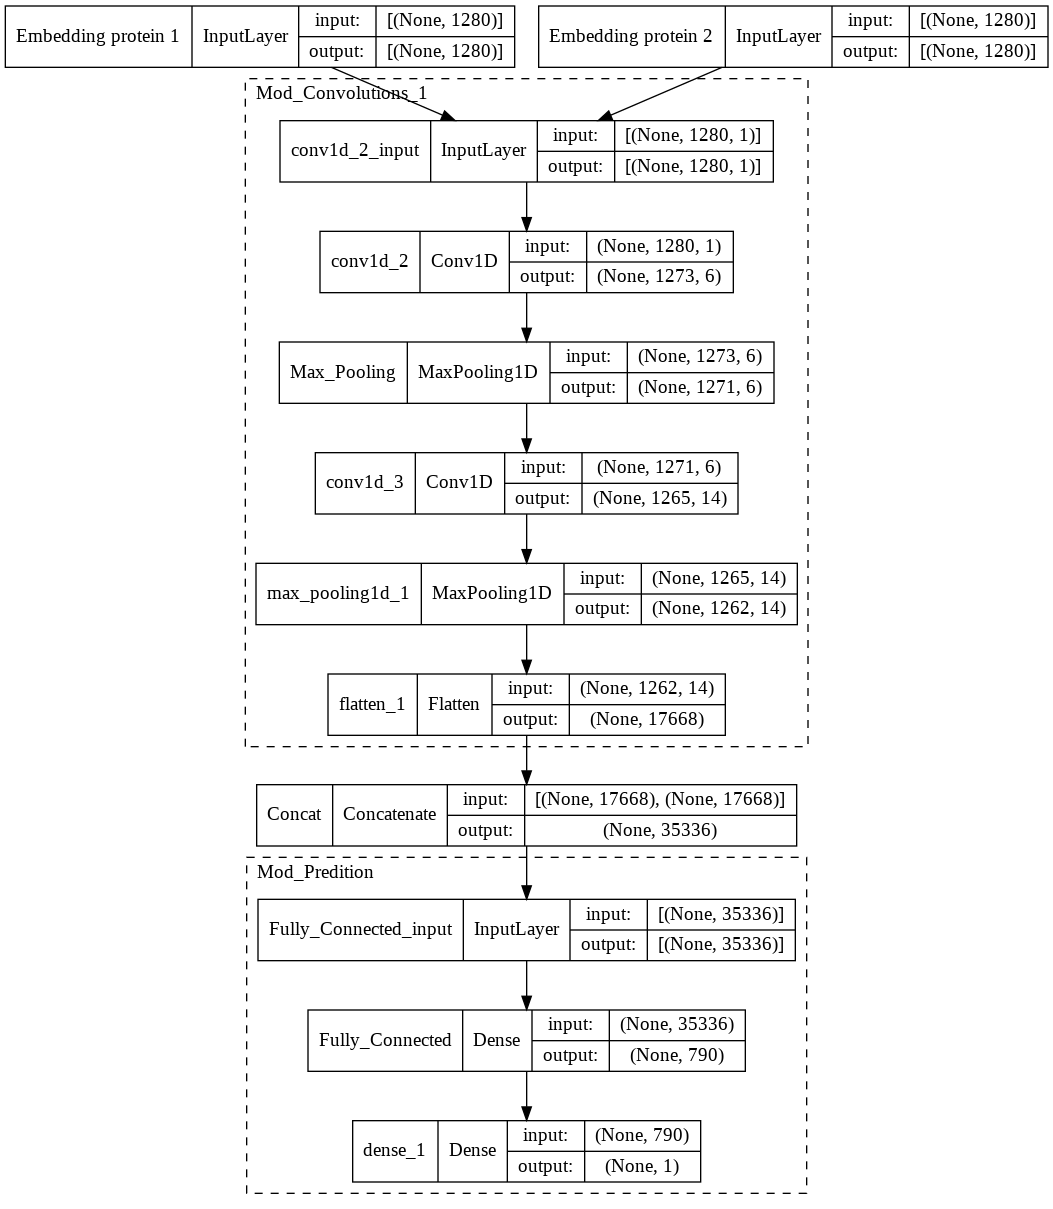

In [ ]:
tf.keras.utils.plot_model(best_model, expand_nested=True, show_shapes=True)

# Training

In [ ]:
X = [X_train_final_smenn_p1, X_train_final_smenn_p2]
history_train = best_model.fit(X, Y_train_smenn, batch_size=128, epochs=40, validation_data=([X_val_p1, X_val_p2], Y_val))

Epoch 1/40
109/109 [==============================] - 12s 23ms/step - loss: 0.5408 - accuracy: 0.7750 - precision: 0.8620 - recall: 0.6549 - f1_score: 0.7031 - val_loss: 0.2528 - val_accuracy: 0.9178 - val_precision: 0.5985 - val_recall: 0.6199 - val_f1_score: 0.6054
Epoch 2/40
109/109 [==============================] - 2s 17ms/step - loss: 0.2075 - accuracy: 0.9102 - precision: 0.9415 - recall: 0.8748 - f1_score: 0.9054 - val_loss: 0.2629 - val_accuracy: 0.9147 - val_precision: 0.5708 - val_recall: 0.6990 - val_f1_score: 0.6245
Epoch 3/40
109/109 [==============================] - 2s 17ms/step - loss: 0.1560 - accuracy: 0.9352 - precision: 0.9552 - recall: 0.9132 - f1_score: 0.9329 - val_loss: 0.2206 - val_accuracy: 0.9239 - val_precision: 0.6317 - val_recall: 0.6301 - val_f1_score: 0.6246
Epoch 4/40
109/109 [==============================] - 2s 17ms/step - loss: 0.1374 - accuracy: 0.9454 - precision: 0.9591 - recall: 0.9305 - f1_score: 0.9433 - val_loss: 0.2254 - val_accuracy: 0.9239

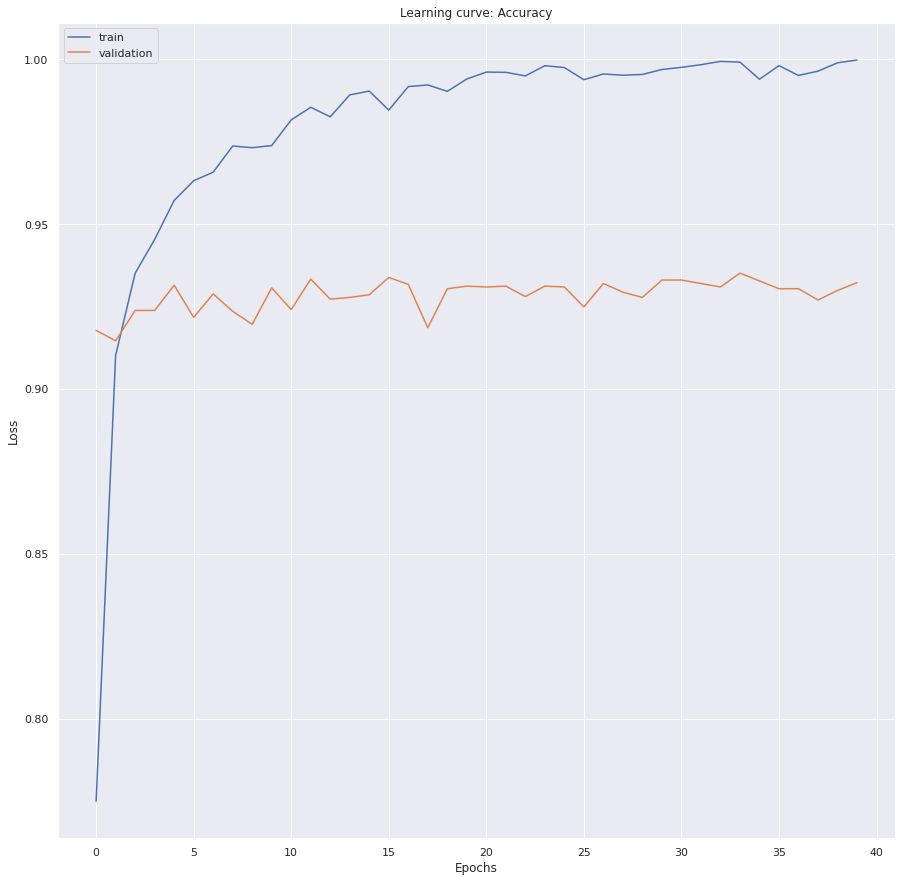

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sb.lineplot(data=history_train.history["accuracy"])
sb.lineplot(data=history_train.history["val_accuracy"])
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
ax.legend(["train", "validation"], loc="upper left")
ax.set_title("Learning curve: Accuracy")
plt.show()

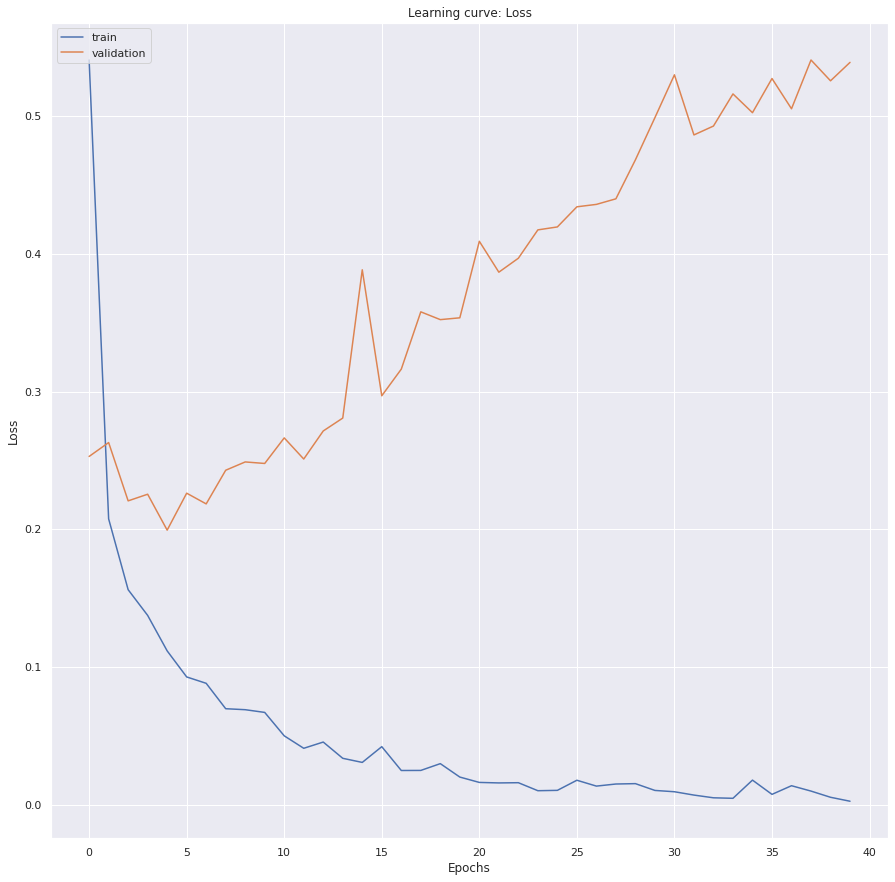

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sb.lineplot(data=history_train.history["loss"])
sb.lineplot(data=history_train.history["val_loss"])
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
ax.legend(["train", "validation"], loc="upper left")
ax.set_title("Learning curve: Loss")
plt.show()

# Evaluation

## Testing

In [ ]:
history_test = best_model.evaluate([X_test_p1, X_test_p2], Y_test)

155/155 [==============================] - 9s 6ms/step - loss: 0.6345 - accuracy: 0.9260 - precision: 0.6645 - recall: 0.5992 - f1_score: 0.5690


In [ ]:
Y_test_predict = best_model.predict([X_test_p1, X_test_p2])
Y_test_predict_class = K.cast(K.greater(K.clip(Y_test_predict, 0, 1), THRESHOLD), "int32")

In [ ]:
report = classification_report(Y_test, Y_test_predict_class, target_names=LABEL_CLASS)
print(report)

                precision    recall  f1-score   support

No interaction       0.95      0.96      0.96      4412
   Interaction       0.66      0.60      0.63       519

      accuracy                           0.93      4931
     macro avg       0.81      0.78      0.79      4931
  weighted avg       0.92      0.93      0.92      4931



## ROC Curve

In [ ]:
def plot_roc_curve(fpr, tpr): 
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.xlabel("False Positive Rate") 
    plt.ylabel("True Positive Rate") 
    plt.show()  

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_predict)

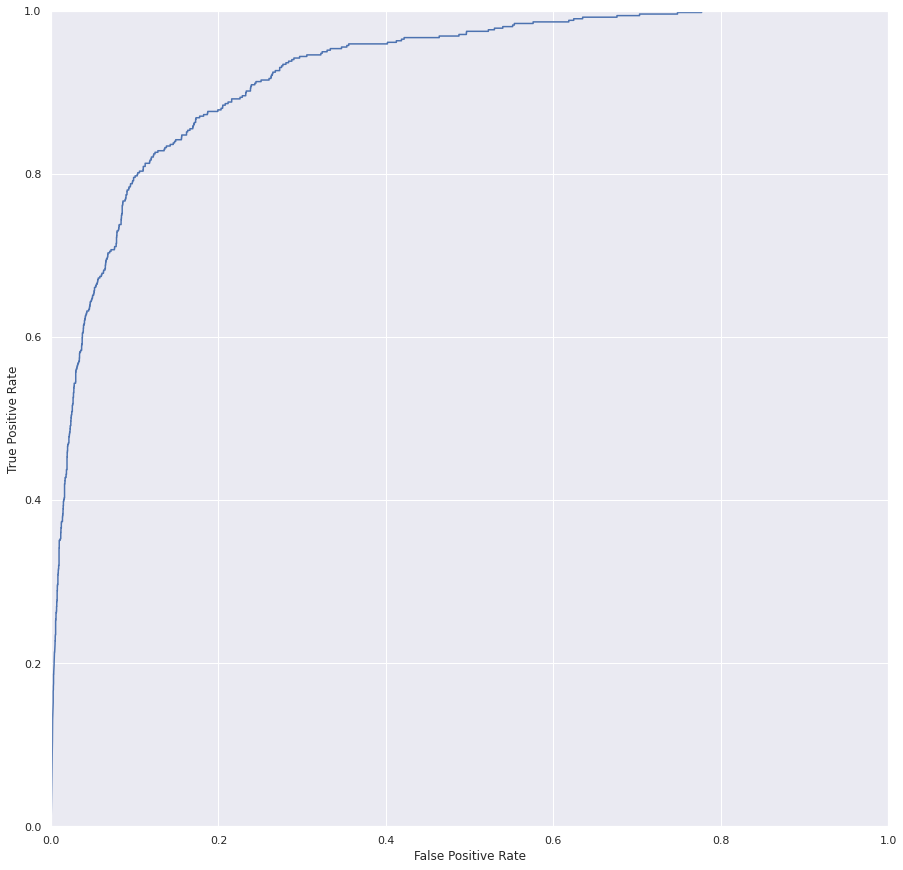

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
plot_roc_curve(fpr, tpr)

In [ ]:
auc_score = roc_auc_score(Y_test, Y_test_predict)
print("AUC: %3f" % auc_score)

AUC: 0.924169


## Precision-Recall Curve

In [ ]:
def plot_pr_curve(l_precision, l_recall): 
    plt.plot(l_precision, l_recall) 
    plt.axis([0,1,0,1]) 
    plt.xlabel("Recall") 
    plt.ylabel("Precision") 
    plt.show()  

In [ ]:
l_precision, l_recall, _ = precision_recall_curve(Y_test, Y_test_predict)

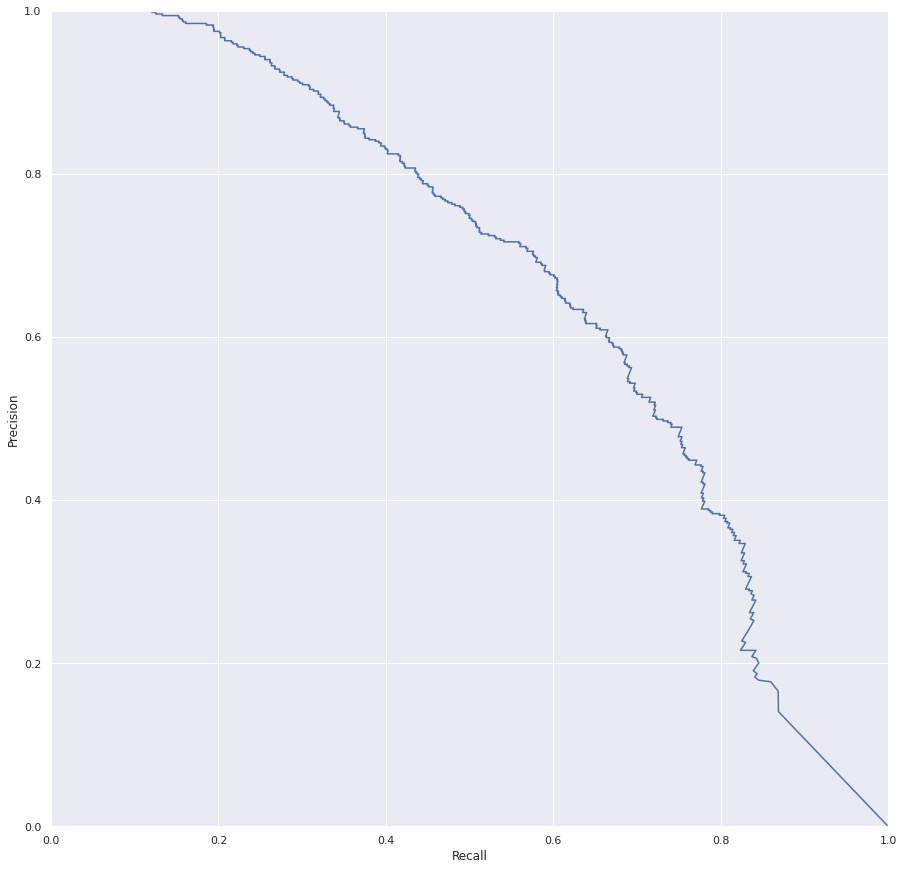

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
plot_pr_curve(l_precision, l_recall)

In [ ]:
auc_score = auc(l_recall, l_precision)
print("PR AUC: %.3f" % auc_score)

PR AUC: 0.666


## Confusion Matrix

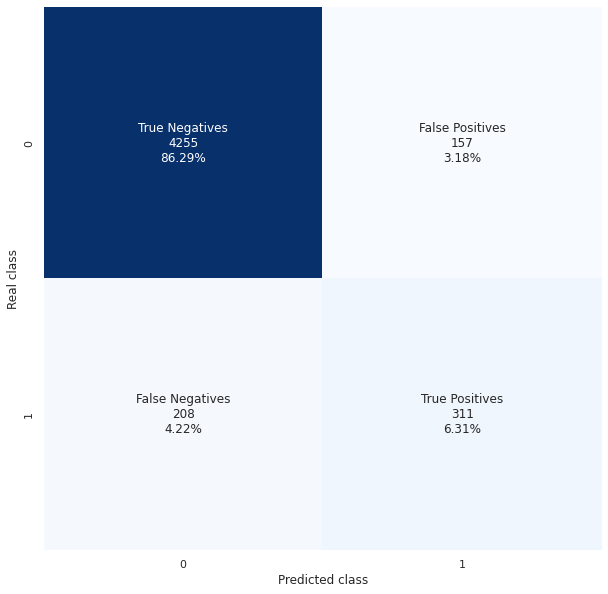

In [ ]:
def plot_confusion_matrix(y, y_pred):
    cfm = confusion_matrix(y, y_pred)
    
    group_names = ["True Negatives", "False Positives", "False Negatives", "True Positives"]
    group_counts = ["{0:0.0f}".format(value) for value in cfm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cfm.flatten()/np.sum(cfm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    fig, ax = plt.subplots(figsize = (10, 10))
    sb.heatmap(cfm, annot=labels, fmt="", cmap="Blues", cbar=False)
    plt.ylabel("Real class")
    plt.xlabel("Predicted class")
    plt.show()

plot_confusion_matrix(Y_test, Y_test_predict_class)

## Evaluation with base models

### With sampling techniques

In [ ]:
def build_fully(units_hidden, activation_hidden):
    emb1_input = Input(shape=(EMB_LENGTH), name="Embedding protein 1")
    emb2_input = Input(shape=(EMB_LENGTH), name="Embedding protein 2")

    merged = Concatenate(name="Concat")([emb1_input, emb2_input])

    predition_module = Sequential([
        Dense(units_hidden, activation=activation_hidden, kernel_regularizer=regularizers.l1_l2()),
        Dense(1, activation="sigmoid")
    ], name="Fully_Connected")
    prediction = predition_module(merged)
    model = Model(inputs=[emb1_input, emb2_input], outputs=prediction)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[metrics.BinaryAccuracy(threshold=THRESHOLD, name="accuracy"), metrics.Precision(thresholds=THRESHOLD, name="precision"), metrics.Recall(thresholds=THRESHOLD, name="recall"), F1(THRESHOLD)])
    return model

In [ ]:
fully_with_smote = build_fully(790, "relu")

In [ ]:
history_train_fully_with_smote = fully_with_smote.fit(X, Y_train_smenn, batch_size=128, epochs=40, validation_data=([X_val_p1, X_val_p2], Y_val))

Epoch 1/40
109/109 [==============================] - 2s 11ms/step - loss: 67.5936 - accuracy: 0.5050 - precision: 0.8804 - recall: 0.0117 - f1_score: 0.0179 - val_loss: 3.2613 - val_accuracy: 0.8968 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/40
109/109 [==============================] - 1s 7ms/step - loss: 3.2024 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 3.2135 - val_accuracy: 0.8968 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/40
109/109 [==============================] - 1s 7ms/step - loss: 3.1213 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 3.1377 - val_accuracy: 0.8968 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/40
109/109 [==============================] - 1s 7ms/step - loss: 3.0712 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000

In [ ]:
history_test_fully_with_smote = fully_with_smote.evaluate([X_test_p1, X_test_p2], Y_test)

155/155 [==============================] - 1s 4ms/step - loss: 2.6793 - accuracy: 0.9057 - precision: 0.5410 - recall: 0.6859 - f1_score: 0.5603


In [ ]:
Y_test_predict_fully_with_smote = fully_with_smote.predict([X_test_p1, X_test_p2])
Y_test_predict_class_fully_with_smote = K.cast(K.greater(K.clip(Y_test_predict_fully_with_smote, 0, 1), THRESHOLD), "int32")

In [ ]:
report_fully_with_smote = classification_report(Y_test, Y_test_predict_class_fully_with_smote, target_names=LABEL_CLASS)
print(report_fully_with_smote)

                precision    recall  f1-score   support

No interaction       0.96      0.93      0.95      4412
   Interaction       0.54      0.69      0.60       519

      accuracy                           0.91      4931
     macro avg       0.75      0.81      0.78      4931
  weighted avg       0.92      0.91      0.91      4931



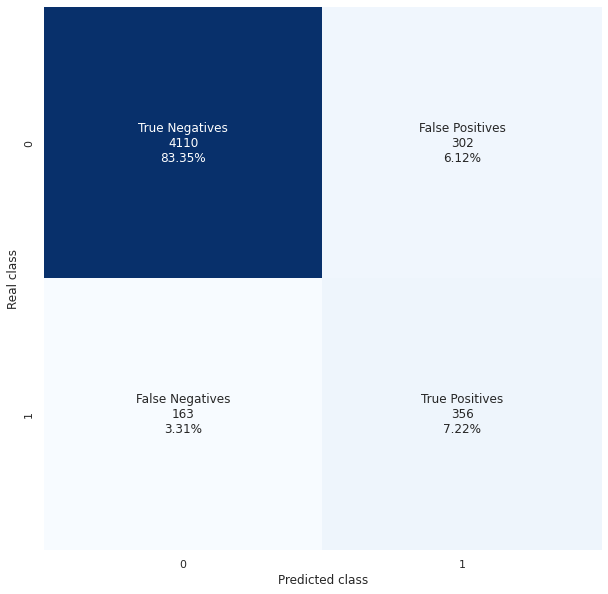

In [ ]:
plot_confusion_matrix(Y_test, Y_test_predict_class_fully_with_smote)

### Without sampling techniques

In [ ]:
fully_without_smote = build_fully(790, "relu")

In [ ]:
history_train_fully_without_smote = fully_without_smote.fit([X_train_final_p1, X_train_final_p2], Y_train_final, batch_size=128, epochs=40, validation_data=([X_val_p1, X_val_p2], Y_val))

Epoch 1/40
61/61 [==============================] - 2s 16ms/step - loss: 117.7318 - accuracy: 0.8998 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 7.3401 - val_accuracy: 0.8968 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/40
61/61 [==============================] - 0s 8ms/step - loss: 3.6905 - accuracy: 0.8998 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 2.8292 - val_accuracy: 0.8968 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/40
61/61 [==============================] - 0s 8ms/step - loss: 2.7725 - accuracy: 0.8998 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 2.7176 - val_accuracy: 0.8968 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/40
61/61 [==============================] - 0s 8ms/step - loss: 2.7148 - accuracy: 0.8998 - precision: 0.0000e+00 - recall: 0

In [ ]:
history_test_fully_without_smote = fully_without_smote.evaluate([X_test_p1, X_test_p2], Y_test)

155/155 [==============================] - 1s 4ms/step - loss: 2.6448 - accuracy: 0.8947 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00


In [ ]:
Y_test_predict_fully_without_smote = fully_without_smote.predict([X_test_p1, X_test_p2])
Y_test_predict_class_fully_without_smote = K.cast(K.greater(K.clip(Y_test_predict_fully_without_smote, 0, 1), THRESHOLD), "int32")

In [ ]:
report_fullywithoutsmote = classification_report(Y_test, Y_test_predict_class_fully_without_smote, target_names=LABEL_CLASS)
print(report_fullywithoutsmote)

                precision    recall  f1-score   support

No interaction       0.89      1.00      0.94      4412
   Interaction       0.00      0.00      0.00       519

      accuracy                           0.89      4931
     macro avg       0.45      0.50      0.47      4931
  weighted avg       0.80      0.89      0.85      4931



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


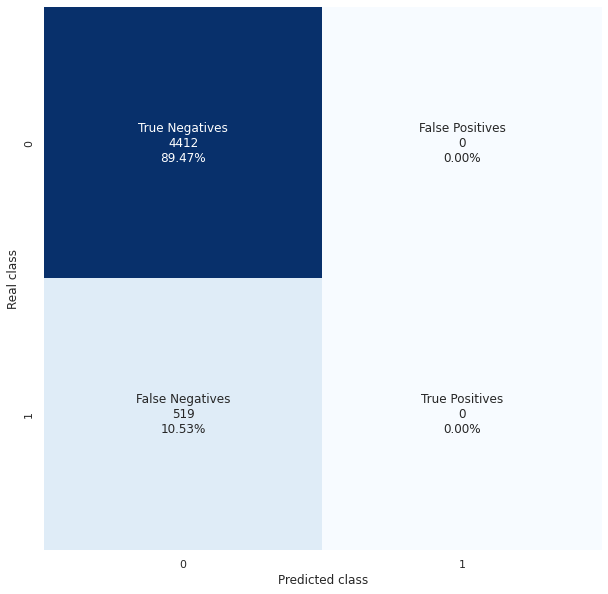

In [ ]:
plot_confusion_matrix(Y_test, Y_test_predict_class_fully_without_smote)

## Evaluation with SVM

In [ ]:
!pip install thundersvm

     |████████████████████████████████| 507 kB 4.2 MB/s 


In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  ## Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0

--2022-01-06 02:31:22--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.19.142
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb [following]
--2022-01-06 02:31:23--  https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?_KTNRDkNzXHHmLSbNEJWh8Cqz34TjG7ST3W1r2llROBmQ4amXS6KCitPZ3DQFUvL5xpiDcZXECImwqrYuxi8XjVEoSlfP

In [ ]:
from thundersvm import SVC

### With sampling techniques

In [ ]:
support_vector_model = SVC()

In [ ]:
support_vector_model.fit(X=X_train_as_matrix_smenn, y=Y_train_smenn)

SVC(class_weight={})

In [ ]:
X_test_stack = np.concatenate((X_test_p1, X_test_p2), axis=1)

In [ ]:
Y_test_predict_svm_with_smote = support_vector_model.predict(X_test_stack)

In [ ]:
report = classification_report(Y_test, Y_test_predict_svm_with_smote, target_names=LABEL_CLASS)
print(report)

                precision    recall  f1-score   support

No interaction       0.98      0.86      0.92      4412
   Interaction       0.42      0.82      0.55       519

      accuracy                           0.86      4931
     macro avg       0.70      0.84      0.73      4931
  weighted avg       0.92      0.86      0.88      4931



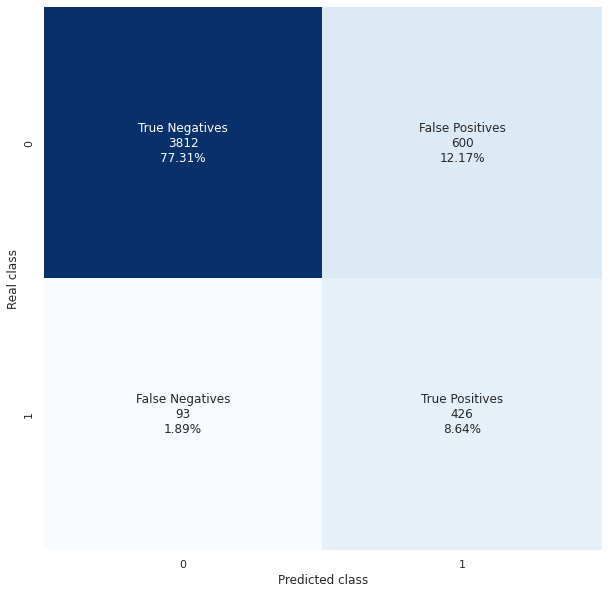

In [ ]:
plot_confusion_matrix(Y_test, Y_test_predict_svm_with_smote)

### Without sampling techniques

In [ ]:
support_vector_model_unbalance = SVC()

In [ ]:
support_vector_model_unbalance.fit(X=X_train_as_matrix, y=Y_train_final)

SVC(class_weight={})

In [ ]:
Y_test_predict_svm_without_smote = support_vector_model_unbalance.predict(X_test_stack)

In [ ]:
report = classification_report(Y_test, Y_test_predict_svm_without_smote, target_names=LABEL_CLASS)
print(report)

                precision    recall  f1-score   support

No interaction       0.90      1.00      0.94      4412
   Interaction       1.00      0.00      0.01       519

      accuracy                           0.90      4931
     macro avg       0.95      0.50      0.48      4931
  weighted avg       0.91      0.90      0.85      4931



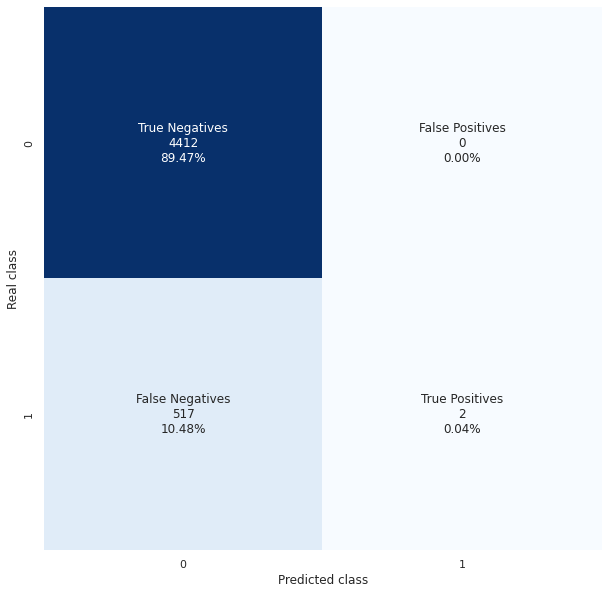

In [ ]:
plot_confusion_matrix(Y_test, Y_test_predict_svm_without_smote)

# Saving model

In [ ]:
best_model.save(f"{PATH_PROJ}/pre-trained/DeepMAS-PPI/DeepMAS-PPI.h5")

In [ ]:
best_model = tf.keras.models.load_model(f"{PATH_PROJ}/pre-trained/DeepMAS-PPI/DeepMAS-PPI.h5", custom_objects={"f1_score": F1(THRESHOLD)})